## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 400000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d  + e + np.random.normal(mean, var, SIZE)

    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 100000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    e = np.random.normal(mean, var, SIZE)
    f= a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})



def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()






verbosity = 0

'''
models = [#[8,8,4],
          #[16,16,8],
          #LogisticRegression(), 
          #Perceptron(),  
          #DecisionTreeClassifier(),
          #LinearSVC(),
          #GaussianNB(),
          #[32,32,16],
          #[64,64,32],
          #[128, 128, 64],
          #[256, 256, 128],
          #[512, 512, 256],
          #[1024, 1024, 512],
          [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024], 
            [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],
            [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],
          #[2048, 2048, 1024],
         ]
model_names = ['n1', 
               'n2',
               'n3',
                'n4', 
               'n5',
               'n6',
                'n7', 
               'n8',
               'n9',

               #'m7', 
               #'m8',
               #'m9',
               #'m10', 
               #'m11a',
               #'m11b',
               #'m11c',
              ]
'''


models = []
model_names = []

num_models = 100
model_layers = [2048,1024,512]
model_layers = [1024,512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/b' + str(i))

print(models, model_names)


df = gen_data()
X = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y = df['g'].values

val_df = gen_data(SIZE = 10000)
x_val = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y_val = df['g'].values




[[1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512]

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), 6)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.01, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/b0


KeyboardInterrupt: 

In [11]:
nb_test = 2000
metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1, 2]
variances = [1,2,3]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df['g']
        x_test2 = perturbed_df[['a', 'b', 'c', 'd', 'e', 'f']]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = ['g'])
            test_df2 = test_df2.join(test_targets2)
'''
            setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
            if setA != {'f'}:
                print("Error in SETA markov blanket")
                #setA = {'f'}
            setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

            if setA != setC:
                causal_dicts[idx][str(m) + '_' + str(v)].append(1)
            else:
                causal_dicts[idx][str(m) + '_' + str(v)].append(0)

'''




0 1
0 2
0 3
1 1
1 2
1 3
2 1
2 2
2 3


'\n            setA = get_MB(get_CG(perturbed_df, tetrad), \'g\', pc)\n            if setA != {\'f\'}:\n                print("Error in SETA markov blanket")\n                #setA = {\'f\'}\n            setC = get_MB(get_CG(test_df2, tetrad), \'g\', pc)\n\n            if setA != setC:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(1)\n            else:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(0)\n\n'

# USING BIC

In [12]:
#the number of times to sample 
times = 5
nb_test = 2000
## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

#metrics_dicts = []
causal_dicts = []
for m in models:
#    metrics_dicts.append(defaultdict(list))
    causal_dicts.append(defaultdict(list))
from pycausal import prior as p
def get_bic(df):
    prior = p.knowledge(requiredirect =  [['a', 'f'], 
                                      ['b', 'f'], 
                                      ['c', 'f'],
                                      ['d', 'f'], 
                                      ['e', 'f'], 
                                      ['f', 'g']
                                     ])
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC / len(df)

for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[['a', 'b', 'c', 'd', 'e', 'f']].values
    y_test = df_test['g'].values
    bic_orig = get_bic(df_test)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
        test_targets = pd.DataFrame(model.predict(x_test), columns = ['g'])
        test_df = test_df.join(test_targets)
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test))  
        bic_pred = get_bic(test_df)
        violation_mean[idx][t] = bic_orig - bic_pred
        violation_mean2[idx][t] = bic_orig - bic_pred
        print(bic_orig - bic_pred)



Times =  0
-0.18894940208547162
-0.20603490174786732
-0.22587450564930922
-0.26378348900803905
-0.1918156405181377
-0.20750661803211612
-0.22353964801277915
-0.22114221090121156
-0.16061814158818466
-0.2080130343668114
-0.17469036877187571
-0.21078237876594574
-0.2565167754232145
-0.20950956008666388
-0.200952385904702
-0.19652142206674172
-0.18124180398948875
-0.17107257488516536
-0.24104793104128497
-0.15528426643998738
-0.2584406834231383
-0.2005493407371386
-0.2343905587954631
-0.18437629122872456
-0.16768004697706473
-0.250491219399815
-0.17462888279776756
-0.2660112594820978
-0.1564808506671338
-0.2219708352970322
-0.19485007277900213
-0.21432688932477673
-0.18782482057717464
-0.22599938076142
-0.11666079984576738
-0.27948622701630876
-0.19967851702101225
-0.19630047017995933
-0.22572452309796054
-0.2375064701029168
-0.1600783975523803
-0.15940797844134957
-0.16641143425796656
-0.21385718195778036
-0.23925689821298057
-0.17525153386621284
-0.2352536397212428
-0.23738367278758776


-0.15835410731244304
-0.18584912917186536
-0.19070459790187888
-0.1822921373277273
-0.22381513196477965
-0.2150334788315411
-0.16606035691933219
Times =  4
-0.19059161504980482
-0.2003279618696654
-0.2228699401041241
-0.2870317882195983
-0.19803117812763338
-0.2269976861123273
-0.18244466611636412
-0.2334894029471104
-0.1740292455400838
-0.21250131055727062
-0.18680916058897434
-0.20558843851918862
-0.2752701129038684
-0.22116852325748315
-0.22456932816366315
-0.19727550358544566
-0.1934661009904639
-0.19368320521670634
-0.2440787544976568
-0.16731930711915144
-0.2819521074144178
-0.1972580534755335
-0.2512969681556392
-0.1853735244364696
-0.1670951081954568
-0.23933827948895559
-0.1965230895760821
-0.26295793375542775
-0.1950612436324315
-0.2283902665410209
-0.19754206748349157
-0.22606766162942638
-0.19940761680079522
-0.23519547504882166
-0.13895026261539467
-0.29777842974217394
-0.2060803646894036
-0.1770146774961021
-0.20723272389647907
-0.24574817659623616
-0.16411174228564773
-0

Model_name =  temp/b0 Violations =  0.0
Average_violations =  -0.18366382420801086 0.008168463895711834
MSE =  1.0564932303595918 0.018176181108151536
Model_name =  temp/b1 Violations =  0.0
Average_violations =  -0.19398358241219515 0.010708684996300772
MSE =  1.053512552378691 0.024085159806626604
Model_name =  temp/b2 Violations =  0.0
Average_violations =  -0.21002664494462336 0.013788196405789778
MSE =  1.0606734037895702 0.02317983210177919
Model_name =  temp/b3 Violations =  0.0
Average_violations =  -0.26567384774208647 0.016300721550873472
MSE =  1.0656163433781078 0.019212490550125964
Model_name =  temp/b4 Violations =  0.0
Average_violations =  -0.188538828777161 0.006326432649709676
MSE =  1.0492981108816337 0.018430568675541027
Model_name =  temp/b5 Violations =  0.0
Average_violations =  -0.20411643598305 0.01872905861867872
MSE =  1.0598034571418309 0.016261503732542832
Model_name =  temp/b6 Violations =  0.0
Average_violations =  -0.19384328353743702 0.01674288456710835

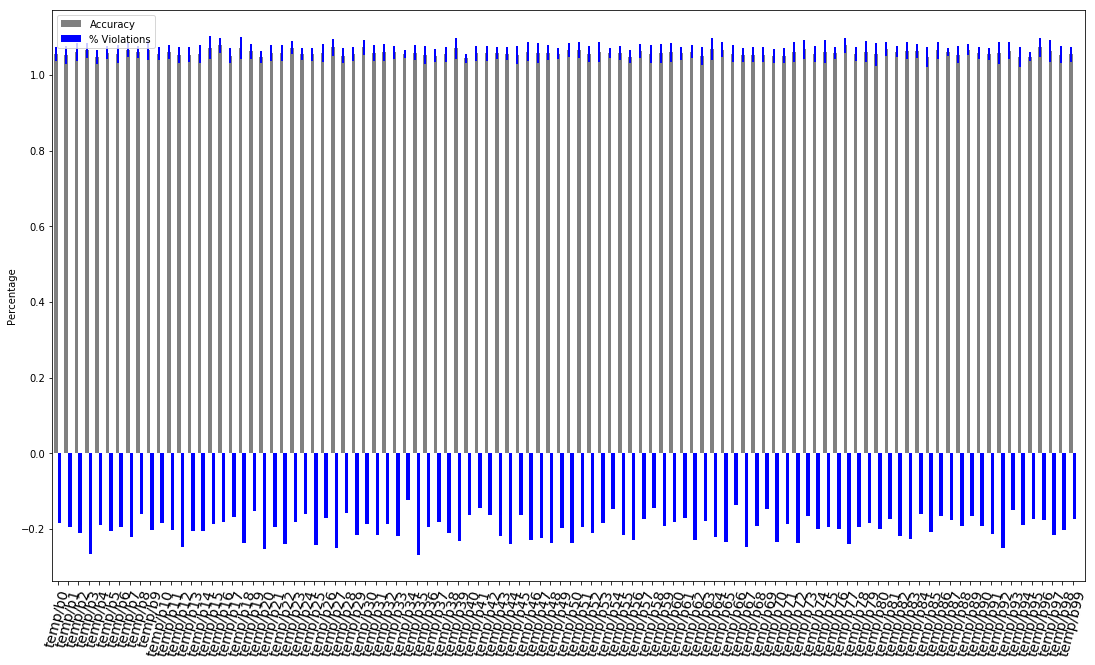

temp/b0
Area under surface (rectangular approx) =  62.43059404937612
Violations =  0.0
Average_violations =  -0.18366382420801086
MSE =  1.0564932303595918
temp/b1
Area under surface (rectangular approx) =  63.2754895527979
Violations =  0.0
Average_violations =  -0.19398358241219515
MSE =  1.053512552378691
temp/b2
Area under surface (rectangular approx) =  63.493828590379024
Violations =  0.0
Average_violations =  -0.21002664494462336
MSE =  1.0606734037895702
temp/b3
Area under surface (rectangular approx) =  66.31841863634567
Violations =  0.0
Average_violations =  -0.26567384774208647
MSE =  1.0656163433781078
temp/b4
Area under surface (rectangular approx) =  63.01835083960572
Violations =  0.0
Average_violations =  -0.188538828777161
MSE =  1.0492981108816337
temp/b5
Area under surface (rectangular approx) =  60.41969949041991
Violations =  0.0
Average_violations =  -0.20411643598305
MSE =  1.0598034571418309
temp/b6
Area under surface (rectangular approx) =  62.652206619146284


In [13]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    #heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
#heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    
VIO = np.abs(VIO)
VIO2 = np.abs(VIO2)


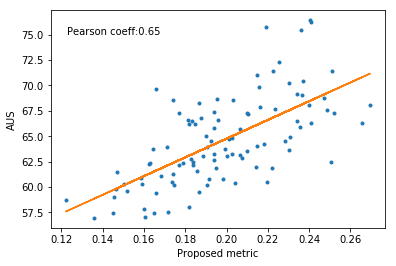

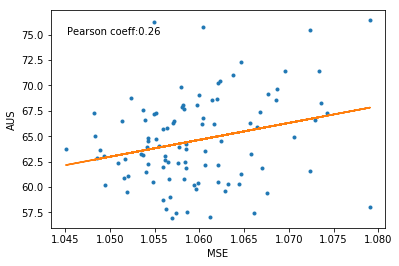

46.286530900115785 92.35095719427781


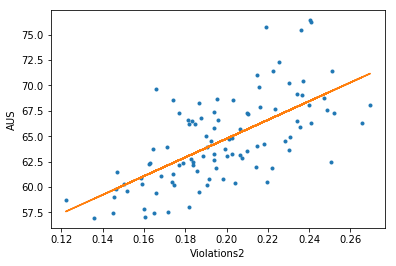

1.0551609962021704 0.022156131035911138


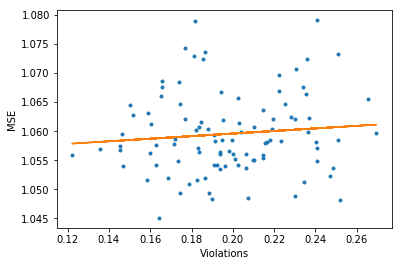

17.906192978308784 25.12603160867848


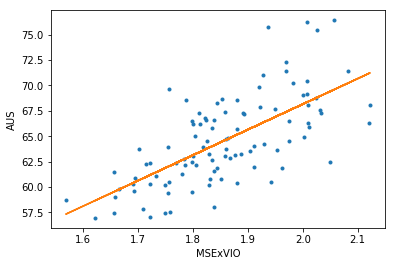

In [39]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex1ProposedVsAUS.pdf')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex1MSEVsAUS.pdf')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(VIO2,AUS, 1)
print(b,m)
ax.plot(VIO2,AUS, '.')
plt.plot(VIO2, b + m * np.array(VIO2), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations2")
ax.set_ylabel("AUS")
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,MSE, 1)
print(b,m)
ax.plot(VIO,MSE, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations")
ax.set_ylabel("MSE")
plt.show()





METRIC = (VIO/np.max(VIO)) + np.array(MSE)*np.array(MSE)
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
print(b,m)
ax.plot(METRIC,AUS, '.')
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSExVIO")
ax.set_ylabel("AUS")
plt.show()

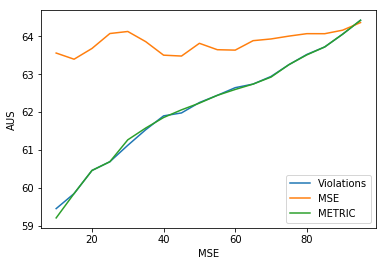

In [15]:
MSE = np.array(MSE)
METRIC = VIO/np.max(VIO)+ MSE
x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'Violations')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  


In [17]:
from scipy.stats import pearsonr
pearsonr(VIO,AUS), pearsonr(MSE,AUS)

((0.6536250312381833, 1.6805086738473368e-13),
 (0.26326010231050256, 0.008136386024668742))